In [34]:
import numpy as np
import matplotlib.pyplot as plt
from diffractio import um, mm
import cupy as cp

%matplotlib ipympl

Main monte carlo diffraction function for GPU.

In [35]:
mempool = cp.get_default_memory_pool()

with cp.cuda.Device(0):
    mempool.set_limit(size=10*1024**3)

def monte_carlo_diffraction_cupy(num_rays, 
                                 final_image_real,
                                 final_image_imag,
                                 pixel_size,
                                 source_yx,
                                 det_yx,
                                 z_prop,
                                 wavelength,
                                 batch_size=int(1e7)):  # Batch size of rays to GPU
    
    # Get number of samples in source and detector
    y_sam = source_yx.shape[1]
    x_sam = source_yx.shape[2]
    y_det = det_yx.shape[1]
    x_det = det_yx.shape[2]
    
    for start_idx in range(0, num_rays, batch_size):
        end_idx = min(start_idx + batch_size, num_rays)
        current_batch_size = end_idx - start_idx

        # Get random pixel samples of the source (or aperture) and the detector
        rand_source_idx_x = cp.random.randint(x_sam, size=current_batch_size)
        rand_source_idx_y = cp.random.randint(y_sam, size=current_batch_size)
        rand_det_idx_x = cp.random.randint(x_det, size=current_batch_size)
        rand_det_idx_y = cp.random.randint(y_det, size=current_batch_size)
        
        # Get the x, y, z coordinates of the source plane
        source_x = source_yx[:, rand_source_idx_y, rand_source_idx_x][1, :]
        source_y = source_yx[:, rand_source_idx_y, rand_source_idx_x][0, :]
        source_z = cp.zeros(current_batch_size)
        
        # Get the x, y, z coordinates of the detector plane
        det_x = det_yx[:, rand_det_idx_y, rand_det_idx_x][1, :]
        det_y = det_yx[:, rand_det_idx_y, rand_det_idx_x][0, :]
        det_z = cp.ones(current_batch_size) * z_prop
        
        # Convert coordinates to a vector for convenience
        ray_source_coord = cp.array([source_z, source_y, source_x])   
        ray_det_coord = cp.array([det_z, det_y, det_x])
        
        # Create ray vector and get magnitude and direction
        ray = ray_det_coord - ray_source_coord
        ray_magnitude = cp.linalg.norm(ray, axis = 0)
        ray_direction = ray / ray_magnitude
        
        # Get the local normal of the source pixel plane, which will also point in the same direction
        # as the detector pixel plane
        source_v = cp.array([1, 0, 0])
        det_v = cp.array([1, 0, 0])
    
        distance = cp.sqrt((source_y - det_y) ** 2 + 
                           (source_x - det_x) ** 2 + 
                           z_prop ** 2)
        
        N = num_rays # Rename number of rays variable so it follows math more closely
        dN0 = N # Number of rays per pixel in point source plane (We only have 1 pixel at source in this test)
        dN1 = N / ((y_det * x_det)) # Number of rays per pixel in detector plane
        
        dS0 = pixel_size # Pixel size at source plane - we have one pixel so the area of the source, or tube of rays is just this pixel
        
        # Apparent area at detector plane - I am not sure exactly why this is correct, or if it is correct, but it gives the right answer
        # for a point source - this link seems to support what I have worked out
        # - https://raytracing.github.io/books/RayTracingTheRestOfYourLife.html#samplinglightsdirectly/gettingthepdfofalight
        # but, the answer I have for dS1 is essentially just the factors that are required to recreate the 
        # rayleigh sommerfeld diffraction integral - it seems a little unneccessary to describe that equation in this way,
        # and perhaps I am missing something. At least does have the cosine term that is expected in the form of 
        # the dot product between the ray and detector vector.
        dS1 = (pixel_size * y_det * x_det) * (cp.dot(ray_direction.T, det_v)) / (distance ** 2)
        
        # See Chapter 2 of Marco Mout thesis - 2.97 onwards
        ws = cp.sqrt((N * dS0) / dN0) * cp.dot(ray_direction.T, source_v) # This extra dot product shows up in the papers description of this method. 
        wp = cp.sqrt((N * dS1) / dN1)
        wi = cp.sqrt(1 / cp.dot(ray_direction.T, det_v))

        # Calculate phase and amplitude factors
        phase = cp.exp(1j * distance * ((2 * cp.pi) / wavelength))
        amplitude = wi * ws * wp
        complex_rays = amplitude * phase

        # Add complex wavefront to each pixel in the image
        cp.add.at(final_image_real, (rand_det_idx_y, rand_det_idx_x), complex_rays.real)
        cp.add.at(final_image_imag, (rand_det_idx_y, rand_det_idx_x), complex_rays.imag)

    final_image = final_image_real + 1j * final_image_imag
    
    # Include final factors which scale image by pixel size, and have an extra term from the rayleigh sommerfeld integral. 
    return final_image * (1 / (num_rays * pixel_size)) * (-1j / wavelength)

Numpy version if we only have a CPU.

In [36]:
def monte_carlo_diffraction_numpy(num_rays, 
                                 final_image_real,
                                 final_image_imag,
                                 pixel_size,
                                 source_yx,
                                 det_yx,
                                 z_prop,
                                 wavelength):  # Batch size set to 100 million
    
    # Get number of samples in source and detector
    y_sam = source_yx.shape[1]
    x_sam = source_yx.shape[2]
    y_det = det_yx.shape[1]
    x_det = det_yx.shape[2]
    
    # Get random pixel samples of the source (or aperture) and the detector
    rand_source_idx_x = np.random.randint(x_sam, size=num_rays)
    rand_source_idx_y = np.random.randint(y_sam, size=num_rays)
    rand_det_idx_x = np.random.randint(x_det, size=num_rays)
    rand_det_idx_y = np.random.randint(y_det, size=num_rays)
    
    # Get the x, y, z coordinates of the source plane
    source_x = source_yx[:, rand_source_idx_y, rand_source_idx_x][1, :]
    source_y = source_yx[:, rand_source_idx_y, rand_source_idx_x][0, :]
    source_z = np.zeros(num_rays)
    
    # Get the x, y, z coordinates of the detector plane
    det_x = det_yx[:, rand_det_idx_y, rand_det_idx_x][1, :]
    det_y = det_yx[:, rand_det_idx_y, rand_det_idx_x][0, :]
    det_z = np.ones(num_rays) * z_prop
    
    # Convert to a coordinates for vector calculus operation
    ray_source_coord = np.array([source_z, source_y, source_x])   
    ray_det_coord = np.array([det_z, det_y, det_x])
    
    # Create ray vector and get magnitude and direction
    ray = ray_det_coord - ray_source_coord
    ray_magnitude = np.linalg.norm(ray, axis = 0)
    ray_direction = ray / ray_magnitude
    
    # Get the local normal of the source pixel plane, which will also point in the same direction
    # as the detector pixel plane
    source_v = np.array([1, 0, 0])
    det_v = np.array([1, 0, 0])

    distance = np.sqrt((source_y - det_y) ** 2 + 
                    (source_x - det_x) ** 2 + 
                    z_prop ** 2)
    
    N = num_rays # Rename number of rays variable so it follows math more closely
    dN0 = N # Number of rays per pixel in point source plane (We only have 1 pixel at source in this test)
    dN1 = N / ((y_det * x_det)) # Number of rays per pixel in detector plane
    
    dS0 = pixel_size # Pixel size at source plane
    
    # Apparent area at detector plane - I am not sure exactly why this is correct, or if it is correct, but it gives the right answer
    # for a point source - this link seems to support what I have worked out
    # - https://raytracing.github.io/books/RayTracingTheRestOfYourLife.html#samplinglightsdirectly/gettingthepdfofalight
    # but, the answer I have for dS1 is essentially just the factors that are required to recreate the 
    # rayleigh sommerfeld diffraction integral - it seems a little unneccessary to describe that equation in this way,
    # and perhaps I am missing something. It does have the cosine term that is expected in the form of 
    # the dot product between the ray and source vector (wh)
    dS1 = (pixel_size * y_det * x_det) * (np.dot(ray_direction.T, det_v)) / (distance ** 2)
    
    # See Chapter 2 of Marco Mout thesis - 2.97 onwards
    ws = np.sqrt((N * dS0) / dN0) * np.dot(ray_direction.T, source_v) # This extra dot product shows up in the papers description of this method. 
    wp = np.sqrt((N * dS1) / dN1)
    wi = np.sqrt(1 / np.dot(ray_direction.T, det_v))

    # Calculate phase and amplitude factors
    phase = np.exp(1j * distance * ((2 * np.pi) / wavelength))
    amplitude = wi * ws * wp
    complex_rays = amplitude * phase

    # Add complex wavefront to each pixel in the image
    np.add.at(final_image_real, (rand_det_idx_y, rand_det_idx_x), complex_rays.real)
    np.add.at(final_image_imag, (rand_det_idx_y, rand_det_idx_x), complex_rays.imag)

    final_image = final_image_real + 1j * final_image_imag
    
    # Include final factors to scale by pixel size, and extra term from rayleigh sommerfeld integral. 
    return final_image * (1 / (num_rays * pixel_size)) * (-1j / wavelength)

Set up coordinates of detector and sample plane, and other variables such as propagation distance and wavelength

In [37]:
detector_width_x = 10000 * um
detector_width_y = 0 * um

num_px_det_x = 1000
num_px_det_y  = 1
num_px_samp_x = 1
num_px_samp_y = 1

detector_px_width_x = detector_width_x / num_px_det_x 
detector_px_width_y = detector_width_y / num_px_det_y

num_pixels = int(num_px_det_x*num_px_det_y)
det_yx_indices = np.indices((num_px_det_y, num_px_det_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 

sample_yx_coords = np.array([[0, 0]])
sample_idx_start_yx = np.array([0, 0])

det_yx_coords = det_yx_coords.T.reshape(2, num_px_det_y, num_px_det_x)
sample_yx_coords = sample_yx_coords.T.reshape(2, num_px_samp_y, num_px_samp_x)

z_prop = 5 * mm
wavelength = 0.638 * um

Run this cell if you want to use numpy instead of cupy

In [38]:
# num_rays=int(1e7)

# # Initialize final image and aperture phase shifts arrays on GPU
# final_image_real = np.zeros([num_px_det_y, num_px_det_x], dtype=np.float64)
# final_image_imag = np.zeros([num_px_det_y, num_px_det_x], dtype=np.float64)

# final_image = monte_carlo_diffraction_numpy(num_rays, 
#                                            final_image_real, 
#                                            final_image_imag, 
#                                            detector_px_width_x,
#                                            sample_yx_coords,
#                                            det_yx_coords,
#                                            z_prop,
#                                            wavelength)

Run this cell if you have a GPU

In [39]:
num_rays=int(1e9)

# Assuming sample_yx_coords and det_yx_coords are defined elsewhere and are numpy arrays, convert them:
sample_yx_coords = cp.asarray(sample_yx_coords)
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)

final_image = monte_carlo_diffraction_cupy(num_rays, 
                                           final_image_real, 
                                           final_image_imag, 
                                           detector_px_width_x,
                                           sample_yx_coords,
                                           det_yx_coords,
                                           z_prop,
                                           wavelength)

det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)

Analytic solution for intensity of a point source using Rayleigh Sommerfeld Theory

In [40]:
r = np.sqrt(det_yx_coords[1, 0, :]**2 + z_prop**2)
k = (2 * np.pi) / wavelength
analytic_point_source = 1.0 * np.exp(1j * k * r) / (r) * ((z_prop) / r) * (- 1j * (1 / wavelength))

Plotting of amplitude of point source.

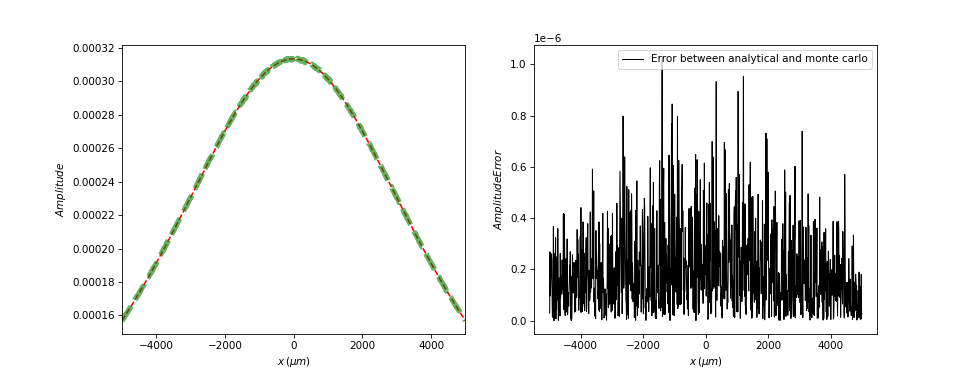

In [45]:

fig, ax = plt.subplots(figsize = (13, 5), nrows = 1, ncols = 2)

ax[0].set_xlabel('$x\,(\mu m)$')
ax[0].set_ylabel('$Amplitude$')
ax[0].set_xlim(left=det_yx_coords[1, 0, 0], right=det_yx_coords[1, 0, -1])
ax[0].plot(det_yx_coords[1, 0, :], np.abs(analytic_point_source), '--r', label='Spherical Wave Analytic')
ax[0].plot(det_yx_coords[1, 0, :], np.abs(final_image[0, :]), '--g', label='Spherical Wave Monte Carlo', linewidth = 5, alpha = 0.6)
ax[1].set_xlabel('$x\,(\mu m)$')
ax[1].set_ylabel('$Amplitude Error$')
ax[1].plot(det_yx_coords[1, 0, :], np.abs(np.abs(final_image[0, :]) - np.abs(analytic_point_source)), 'k', label='Error between analytical and monte carlo', linewidth = 1, alpha = 1)
plt.legend()

mempool.free_all_blocks()
